In [1]:
epochs = 500
batch_size = 1
lr = 1e-3

In [2]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(404, 13) (404,) (102, 13) (102,)


In [3]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [4]:
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [5]:
def build_model():
    from keras import models
    from keras import layers
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [6]:
import numpy as np

k = 4
num_val_samples = len(x_train) // k
mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    mae_histories.append(mae_history)
    print(tf.get_default_graph())

processing fold # 0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using TensorFlow backend.



processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
average_mae_histories = [
    np.mean([x[i] for x in mae_histories]) for i in range(epochs)]

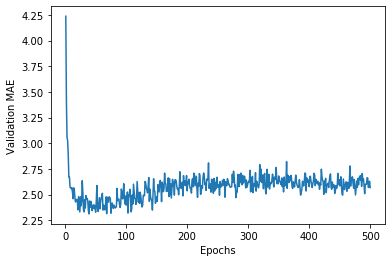

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_histories) + 1), average_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

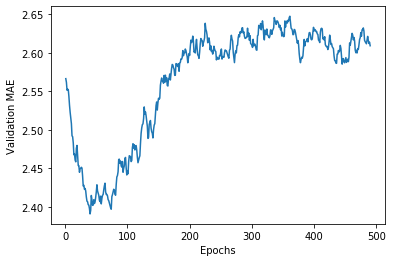

In [9]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_histories = smooth_curve(average_mae_histories[10:])

plt.plot(range(1, len(smooth_mae_histories) + 1), smooth_mae_histories)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [10]:
model = build_model()
model.fit(x_train, y_train,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

102/102 [==============================] - 0s 368us/step


In [11]:
test_mae_score

2.832794189453125